In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [41]:
votes = pd.read_csv("../data/pivot.csv")

Codes:
Yes = 0, No = 1, Abstain = 2, Not Participated = 3, Excused = 4, President = 5, NA = -1

# Handling Missing Values
Impute missing values with the mean along the rows. Reasoning: If a parlamentarian didn't participate in the vote, we want him to be as neutral as possible, such that he isn't defined by votes he didn't participate in.

In [43]:
yesno = votes.iloc[:,1:].copy()
yesno[yesno>1] = np.NaN
yesno[yesno<0] = np.NaN

In [48]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
yesno_imp = imp.fit_transform(yesno.T).T

# Global PCA

In [54]:
pcafit = PCA().fit(yesno_imp.T)

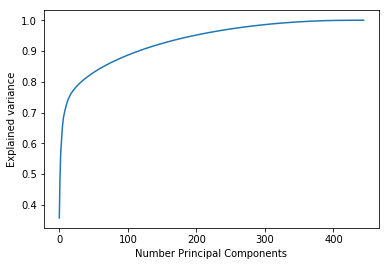

In [72]:
expl_var = np.cumsum(pcafit.explained_variance_ratio_)
plt.plot(expl_var)
plt.ylabel("Explained variance")
plt.xlabel("Number Principal Components")
plt.show()

> Very few principal components seem to explain 75% of the data variance already. We thus retain only those principal components for the future analysis.

In [79]:
nb_retain = np.where(expl_var>.75)[0][0]
print("Number retained principal components:", nb_retain)
pc = pcafit.transform(yesno_imp.T)[:,:nb_retain]

Number retained principal components: 15


# Taking a first peek at the data

> For a first visualization of our data, we perform a TSNE dimensionality reduction. This is a way to show data that lies on a complex manifold in two dimensions, and allows to give intuition about what the data looks like.

In [92]:
tsne = TSNE().fit_transform(pc)

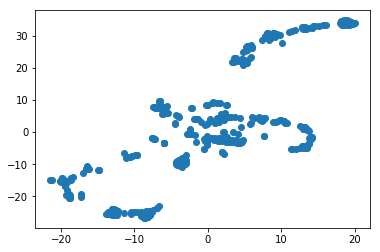

In [97]:
plt.scatter(tsne[:,0], tsne[:,1])
plt.xlabel("TSNE Direction 1")
plt.ylabel("TSNE Direction 2")
plt.show()

> The TSNE plot indicates that certain politicians group together, which manifests in several clusters forming. However, note that the results of the TSNE should be taken with a grain of salt, since its complexity sometimes leads to unexpected results.

# Finding Clusters

## KMeans Clustering

> We perform k-means clustering in order to cluster our politicians based on their voting behavior. We do this on the principal components calculated above, in order to avoid the curse of dimensionality.

> We run k-means clustering with a range of possible number of clusters. Then, we determine the optimal number of clusters using a so-called knee-plot, which plots the within-cluster variance against the number of clusters. 

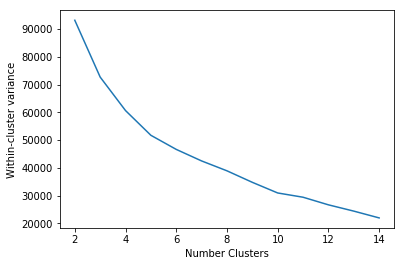

In [111]:
cluster_range = np.arange(2, 15)
kmeans_fit = []
inertia = []
for nc in cluster_range:
    cl = KMeans(n_clusters=nc).fit(pc)
    kmeans_fit.append(cl)
    inertia.append(cl.inertia_)
    
plt.plot(cluster_range, inertia)
plt.ylabel("Within-cluster variance")
plt.xlabel("Number Clusters")
plt.show()

> In the knee-plot, the optimal number of clusters can be determined as the "knee" of the graph. In our case, this is somewhat hard to determine, but 6 clusters seem plausible.

In [119]:
ix = np.where(cluster_range==6)[0][0]
kmeans_cl = kmeans_fit[ix].labels_